# Trabalho 2 - Operações geométricas

#### Aluno: Pedro Fontebasso Lemos

## Objetivos e metas

O objetivo é utilizar das transformações geométricas para ajustar a imagem do Stormtrooper
para ocupar a tela inteira, de forma que haja pouca ou nenhuma perda.

Os passos serão os seguintes (eles serão aprofundados conforme forem demonstrados no código):

### Cálculo dos parâmetros

Os vértices do papel foram previamente informados,
seus valores finais serão proporcionais aos de uma folha sendo A4:

| nome | originais(linha,coluna) | coordenadas transformadas |
|------|-------------------------|---------------------------|
| s1   | (1071, 30)              | (3508, 0)                 |
| s2   | (117, 531)              | (0, 0)                    |
| s3   | (225, 1410)             | (0, 2480)                 |
| s4   | (1302, 1239)            | (3508,2480)               |


Para descobrirmos a matriz de transformação que será aplicada, é necessário utilizar o método dos mínimos quadrados.

Sabe-se que A * X = L
sendo: 
* A a matriz dos coeficientes dos parâmetros
* X os parâmetros verdadeiros
* L um vetor com as coordenadas finais

Colocando o X como variável que queremos descobrir, obtemos:

$\hat{X}= {(A^T*A)}^{-1} * {A^T} * L$

Sendo $\hat{X}$ a matriz de transformação em forma de um vetor.

Assim, precisamos então de A e L. Tendo como base o modelo de transformação:

sendo u,v as coordenadas que queremos atingir e x,y as coordenadas originais.


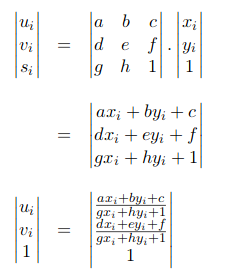

In [3]:
from IPython.display import Image
Image(filename="formulas.png")

**(Imagem retirada dos slides de aula)**

Chegamos aos seguintes valores para **CADA PIXEL i**:

${u}_i={ax}_i+{by}_i+c+ 0d+ 0e+ 0f−{gx}_i{u}_i−{hy}_i{u}_i$

${v}_i= 0a+ 0b+ 0c+{dx}_i+{ey}_i+f−{gx}_i{v}_i−{hy}_i{v}_i$

Separamos essa expressão em duas matrizes, sendo L o vetor com os valores ${u}_i,{v}_i$ e o resto da formula fica em A:


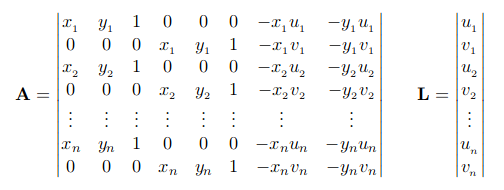

In [5]:
Image(filename="formulas2.png")

**(Imagem retirada dos slides de aula)**

Agora que temos A e L, podemos obter X:

$\hat{X}= {(A^T*A)}^{-1} * {A^T} * L$

Depois de obtido o vetor X, nós adicionamos um 1 ao final para normalizar a transformação e o transformamos numa matriz quadrada 3x3 que é a nossa transformação.

Quando formos percorrer os pixels da imagem de saída, precisamos aplicar a matriz inversa dessa transformação, para assim, obtermos a coordenada correspondente na imagem de entrada e aplicarmos a reconstrução.

### Reconstrução

O valor do pixel na imagem original não é 100% exato, pois houveram diversas mudanças na estrutura da imagem. Para melhorarmos a qualidade da transformação podemos aplicar uma interpolação bilinear. Esta irá pegar os valores dos 4 pontos que estão em torno do pixel alvo, realizar um cálculo e retornar seu valor aproximado. Diminuindo assim a discrepância e suavizando os pixels. 

In [8]:
import numpy as np

def bilinear_interpolation(x,y, img):
    height, width = img.shape

    # transformando em um array numpy para utilizar os metodos nativos da biblioteca
    # operando as matrizes de coordenadas
    x = np.asarray(x)
    y = np.asarray(y)

    # pegando os vertices dos 4 pontos (x0,y0) e (x1,y1)
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    # truncando os valores entre 0 e altura ou largura
    x0, x1 = np.clip(x0, 0, height-1), np.clip(x1, 0, height-1)
    y0, y1 = np.clip(y0, 0, width-1), np.clip(y1, 0, width-1)

    # pegamos os 4 valores dos 4 pontos próximos do desejado
    # é separado por [x,y] em vez de [x][y], pois x e y são matrizes de coordenadas
    pa, pb, pc, pd = img[ x0, y0 ], img[ x1, y0 ], img[ x0, y1 ], img[ x1, y1 ]

    # Calculamos o produto entre as distâncias das coordenadas
    wa, wb, wc, wd = (x1-x) * (y1-y), (x1-x) * (y-y0), (x-x0) * (y1-y), (x-x0) * (y-y0)

    return wa*pa + wb*pb + wc*pc + wd*pd

## Código da transformação

Matriz de transformação inversa: 
 [[ 1.75895496e-01  3.64961971e-02  1.10443811e+02]
 [-1.37117815e-01  3.05704081e-01  5.01244989e+02]
 [-7.55262419e-05 -2.05711276e-05  9.43964197e-01]]


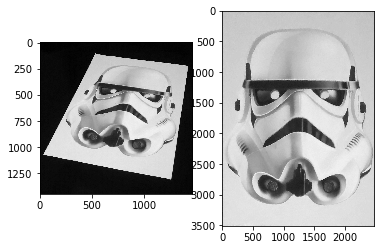

In [14]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from collections import namedtuple


# Dimensões da imagem =  1456 x 1448 pixels
source_img = cv2.imread("trooper.jpg", 0)
s_height, s_width = source_img.shape

# Criando o suporte que ira armazenar a imagem final
# Tamanho folha A4 = 2480 x 3508 pixels
r_height, r_width = 3508, 2480
result_img = np.zeros((r_height, r_width), np.uint8)


### ------ DESCOBRINDO OS PARAMETROS DA TRANSFORMACAO

# Sabendo que os vértices do papel são
#
# s2 -- s3
# |     |
# s1 -- s4

Pixel = namedtuple('Pixel', 'x y')

s1 = Pixel(1071, 30) #    --> (3508, 0)
s2 = Pixel(117, 531) #    --> (0, 0)
s3 = Pixel(225, 1410) #   --> (0, 2480)
s4 = Pixel(1302, 1239) # --> (3508,2480)

source_pixels = [s1,s2,s3,s4]

# Queremos transforma-los em:

r1 = Pixel(3507,0)
r2 = Pixel(0,0)
r3 = Pixel(0,2479)
r4 = Pixel(3507, 2479)

result_pixels = [r1,r2,r3,r4]


# Construindo A
def generate_A_and_L_matrix(source_pixels, result_pixels):
  A = []
  L = []
  for pixel in list(zip(source_pixels, result_pixels)):
    L.append([pixel[1].x])
    L.append([pixel[1].y])

    u = [pixel[0].x, pixel[0].y, 1, 0, 0, 0, (-pixel[0].x * pixel[1].x), (-pixel[0].y * pixel[1].x)]
    v = [0, 0, 0, pixel[0].x, pixel[0].y, 1, (-pixel[0].x * pixel[1].y), (-pixel[0].y * pixel[1].y)]
    A.append(u)
    A.append(v)

  A = np.array(A)
  L = np.array(L)
  return A, L

A, L = generate_A_and_L_matrix(source_pixels, result_pixels)


# Agora que temos A e L, queremos X:
def calculate_transformation_matrix(A):
  # x^ = (A^t.A)^−1 * A^t * L
  At = np.transpose(A) # A^t
  AtA = np.matmul(At, A) # A^t * A
  AtA_inv = np.linalg.inv(AtA)# (A^t * A)^−1

  Xtemp = np.matmul(AtA_inv, At) # (A^t.A)^−1 * A^t
  Xfinal = np.matmul(Xtemp, L) # (A^t * A)^−1 * A^t * L
  Xfinal = np.append(Xfinal, [1])# Adicionando 1 ao final para poder
                                # converter numa matriz 3x3 de transformacao

  # Convertendo para matriz de transformacao 3x3
  transformation_matrix = np.zeros((3, 3), np.float)
  t_width = len(transformation_matrix)
  t_height = len(transformation_matrix[0])
  counter = 0

  for x in range(t_height):
    for y in range(t_width):
      transformation_matrix[x][y] = Xfinal[counter]
      counter += 1
  return transformation_matrix

transformation_matrix = calculate_transformation_matrix(A)

### ------ APLICANDO A TRANSFORMACAO 

# invertendo a matriz para o cálculo do pixel na matriz resultante
inverse_transformation_matrix = np.linalg.inv(transformation_matrix)
print('Matriz de transformação inversa: \n', inverse_transformation_matrix)
# Para cada pixel na imagem de saída

index_matrix = np.indices((r_height,r_width))

# Aplicar a matriz de transformacao nas coordenadas normalizadas
point = np.matmul(
  inverse_transformation_matrix,
  np.array( [[index_matrix[0]],
            [index_matrix[1]],
            [1]
          ]))

# O resultado da transformação não vai estar normalizado, logo:
point = point/point[2] # normalizar o resultado

x_array = point[0][0].astype(int)
y_array = point[1][0].astype(int)

# Aplicar a interpolação bilinear
result_img = bilinear_interpolation(x_array,y_array, source_img)

cv2.imwrite('result.jpg', result_img)

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(source_img, cmap="gray")
f.add_subplot(1, 2, 2)
plt.imshow(result_img, cmap="gray")
plt.show(block=True)


### Conclusão:

Pode-se observar que a imagem foi transformada com successo. Houve pouca perda de qualidade em relação a imagem original. Ter o tamanho da folha A4 de antemão e a transformação bilinear diminuiram as perdas.
Observa-se também que, pela matriz de transformação inversa, a transformação foi projetiva, possuindo um cisalhamento, rotação e uma mudança na escala da imagem. A proporção das distâncias também foram mantidas. 